In [1]:
# Libraries

import matplotlib
import numpy
import os
import platform
import shutil
import sys
import warnings

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.data.analysis import analysis_annotation
from source.python.data.analysis import analysis_assembly
from source.python.data.analysis import analysis_metadata
from source.python.data.analysis import analysis_tpm
from source.python.io            import loader
from source.python.io            import writer
from source.python               import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [4]:
# Setup some directory paths

# 0 - none
# 1 - transcript global avg >  1
# 2 - transcript global avg >  5
# 3 - control 
# 4 - control + unstressed

FILTER_ID = 0
SUBFOLDER = 'filter' + str(FILTER_ID)

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA   = os.path.join(OUT,      'nbp01-filter', SUBFOLDER)
OUT_PLOT   = os.path.join(OUT_DATA, 'plot')
RES_GENOME = os.path.join(RES,      'genome')
RES_NBP00  = os.path.join(OUT,      'nbp00-analysis')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_GENOME}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp01-filter\filter0
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp01-filter\filter0\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\resources\genome


In [5]:
# Load the updated and synchronized data

gene_assembly = loader.load_faidx(
	filename  = os.path.join(RES_GENOME, 'arabidopsis-r36', 'gene-assembly.fa')
)

gene_annotation = loader.load_csv(
	filename   = os.path.join(RES_NBP00, 'gene-annotation.csv'),
	low_memory = False
)

tissue_metadata = loader.load_csv(
	filename = os.path.join(RES_NBP00, 'tissue-metadata.csv')
)

tissue_tpm = loader.load_csv(
	filename = os.path.join(RES_NBP00, 'tissue-tpm.csv')
)

In [6]:
# Define filtering factors

FILTER = {
	'id'                          : FILTER_ID,
	'desc'                        : 'none',
	'keep_transcript'             : 'longest_per_mrna',
	'keep_age'                    : None,
	'keep_perturbation'           : None,
	'keep_tissue'                 : None,
	'keep_group'                  : None,
	'tissue_percentage_threshold' : 0.01,

	# Per sample filter
	'sample_filter_global' : {
		'max' : 0.0,
		'sum' : 0.0,
		'avg' : 0.0,
		'std' : 0.0,
		'px0' : [
			0.0,
			0.0
		]
	},

	# Per transcript filter
	'transcript_filter_global' : {
		'max' : 0.0,
		'sum' : 0.0,
		'avg' : 0.0,
		'std' : 0.0,
		'px0' : [
			0.0,
			0.0
		]
	},

	# Per tissue-transcript filter
	'transcript_filter_tissue' : {
		'max' : 0.0,
		'sum' : 0.0,
		'avg' : 0.0,
		'std' : 0.0,
		'px0' : [
			1.0,
			0.5
		]
	}
}

if FILTER_ID == 1 :
	FILTER['desc']                            = 'transcript global avg > 1'
	FILTER['transcript_filter_global']['avg'] = 1.0

if FILTER_ID == 2 :
	FILTER['desc']                            = 'transcript global avg > 5'
	FILTER['transcript_filter_global']['avg'] = 5.0

if FILTER_ID == 3 :
	FILTER['desc']              = 'control'
	FILTER['keep_perturbation'] = ['control']

if FILTER_ID == 4 :
	FILTER['desc']              = 'control + unstressed'
	FILTER['keep_perturbation'] = ['control', 'unstressed']

# 2. Annotation

In [7]:
# Keep only the longest transcripts per gene

gcount = gene_annotation['Gene'].nunique()
tcount = gene_annotation['Transcript'].nunique()

if FILTER['keep_transcript'] == 'longest_per_mrna' :
	data = gene_annotation.copy()
	data = data[data['Type'] == 'mRNA']

	data = data[data.groupby('Gene')['Length'    ].transform(max) == data['Length']]
	data = data[data.groupby('Gene')['Transcript'].transform(min) == data['Transcript']]

	gene_annotation = gene_annotation[gene_annotation['Transcript'].isin(data['Transcript'])]

print('Gene       : {:} -> {:}'.format(gcount, gene_annotation['Gene'].nunique(dropna = True)))
print('Transcript : {:} -> {:}'.format(tcount, gene_annotation['Transcript'].nunique(dropna = True)))

Gene       : 27420 -> 27420
Transcript : 48113 -> 27420


# 3. Metadata

In [8]:
# Drop any tissue below a given threshold

threshold = FILTER['tissue_percentage_threshold']
threshold = round(threshold * len(tissue_metadata))
samples   = list()

if threshold > 0 :
	for tissue, dataframe in tissue_metadata.groupby('Tissue') :
		if len(dataframe) < threshold :
			samples.append(tissue)

	tissue_metadata = tissue_metadata.loc[~tissue_metadata['Tissue'].isin(samples)]

print('Drop threshold : {}'.format(threshold))
print('Drop count     : {}'.format(len(samples)))
print('Drop groups    : {}'.format(', '.join(samples)))

Drop threshold : 41
Drop count     : 3
Drop groups    : other, senescence_green, senescence_reproductive


# 4. Filter

In [9]:
# Filter samples that are problematic globally (looks at entire sample through all transcripts)

dataframe, sample_filter = analysis_tpm.filter_samples(
	data    = tissue_tpm,
	cutoff  = FILTER['sample_filter_global']
)

if len(sample_filter) > 0 :
	item = list(sample_filter.keys())[0]
	data = dataframe[item].to_numpy()

	print()
	print(f'Sample <{item}> has a sum expression : {data.sum():9.4f}')
	print(f'Sample <{item}> has a max expression : {data.max():9.4f}')
	print(f'Sample <{item}> has a min expression : {data.min():9.4f}')

if len(sample_filter) > 0 :
	array = list(sample_filter.keys())
	tissue_tpm = tissue_tpm.drop(columns = array)

Problematic items found : 0


In [10]:
# Filter genes that are problematic globally (looks at entire transcript through all samples)

dataframe, gene_filter = analysis_tpm.filter_genes(
	data    = tissue_tpm,
	cutoff  = FILTER['transcript_filter_global']
)

if len(gene_filter) > 0 :
	item = list(gene_filter.keys())[0]
	data = dataframe[item].to_numpy()

	print()
	print(f'Gene <{item}> has a sum expression : {data.sum():9.4f}')
	print(f'Gene <{item}> has a avg expression : {data.mean():9.4f}')
	print(f'Gene <{item}> has a max expression : {data.max():9.4f}')
	print(f'Gene <{item}> has a min expression : {data.min():9.4f}')

if len(gene_filter) > 0 :
	array = list(gene_filter.keys())
	tissue_tpm = tissue_tpm[~tissue_tpm['Transcript'].isin(array)]

Problematic items found : 20 --> AT1G24475.1 ; var(TPM) = 0.0

Gene <AT1G24475.1> has a sum expression :    4.1380
Gene <AT1G24475.1> has a avg expression :    0.0010
Gene <AT1G24475.1> has a max expression :    0.0010
Gene <AT1G24475.1> has a min expression :    0.0010


In [11]:
# Check for sample matching between tpm and metadata tables

x = set(tissue_metadata['Sample'].dropna())
y = set(tissue_tpm.columns[1:].dropna())

sample_i = list(x.intersection(y))
sample_x = list(x.difference(y))
sample_y = list(y.difference(x))

print(f'Samples in <tissue-metadata> : {len(sample_i)} / {len(x)}')
print(f'Samples in <tissue-tpm>      : {len(sample_i)} / {len(y)}')
print()
print(f'Samples missing in <tissue-metadata> : [{len(sample_y)}] ' + ' '.join(sample_y[:5]) + (' ...' if len(sample_y) > 5 else ''))
print(f'Samples missing in <tissue-tpm>      : [{len(sample_x)}] ' + ' '.join(sample_x[:5]) + (' ...' if len(sample_x) > 5 else ''))

if len(sample_x) > 0 :
	tissue_metadata = tissue_metadata[~tissue_metadata['Sample'].isin(sample_x)]

if len(sample_y) > 0 :
	tissue_tpm = tissue_tpm.drop(columns = sample_y)

Samples in <tissue-metadata> : 4077 / 4077
Samples in <tissue-tpm>      : 4077 / 4138

Samples missing in <tissue-metadata> : [61] SRR5591029 SRR1580564 SRR5591027 ERR3281000 SRR7889744 ...
Samples missing in <tissue-tpm>      : [0] 


In [12]:
# Check for gene matching between tpm and annotation tables

x = set(tissue_tpm['Transcript'].dropna())
y = set(gene_annotation['Transcript'].dropna())

gene_i = list(x.intersection(y))
gene_x = list(x.difference(y))
gene_y = list(y.difference(x))

print(f'Samples in <tissue-tpm>      : {len(gene_i)} / {len(x)}')
print(f'Samples in <gene-annotation> : {len(gene_i)} / {len(y)}')
print()
print(f'Genes missing in <tissue-tpm>      : [{len(gene_y)}] ' + ' '.join(gene_y[:5]) + (' ...' if len(gene_y) > 5 else ''))
print(f'Genes missing in <gene-annotation> : [{len(gene_x)}] ' + ' '.join(gene_x[:5]) + (' ...' if len(gene_x) > 5 else ''))

if len(gene_x) > 0 :
	tissue_tpm = tissue_tpm[~tissue_tpm['Transcript'].isin(gene_x)]

if len(gene_y) > 0 :
	gene_annotation = gene_annotation[~gene_annotation['Transcript'].isin(gene_y)]

Samples in <tissue-tpm>      : 27403 / 48339
Samples in <gene-annotation> : 27403 / 27420

Genes missing in <tissue-tpm>      : [17] AT2G03823.1 AT3G26355.1 AT5G23115.1 AT5G05285.1 AT4G12485.1 ...
Genes missing in <gene-annotation> : [20936] AT3G52260.4 AT1G23690.2 AT1G61420.2 AT3G19910.2 AT5G66810.4 ...


# 5. Filter Groups

In [13]:
# Filter genes that are problematic locally (looks at entire transcript through grouped samples; at least one group must satisfy the filter to keep)

gene_common, gene_filter = analysis_tpm.filter_genes_per_group(
	metadata = tissue_metadata,
	tpm      = tissue_tpm,
	group    = 'Tissue',
	cutoff   = FILTER['transcript_filter_tissue']
)

if len(gene_common) > 0 :
	tissue_tpm = tissue_tpm[~tissue_tpm['Transcript'].isin(gene_common)]

Problematic items found : 9216 --> AT1G01060.6 ; p50(TPM) < 1.0
Problematic items found : 12240 --> AT1G01060.6 ; p50(TPM) < 1.0
Problematic items found : 10191 --> AT1G01030.1 ; p50(TPM) < 1.0
Problematic items found : 11541 --> AT1G01060.6 ; p50(TPM) < 1.0
Problematic items found : 10653 --> AT1G01060.6 ; p50(TPM) < 1.0

Problematic items found : 6824 --> AT1G09080.2 ; p50(TPM) < 1.0 @ seedling


In [14]:
# Check for gene matching between tpm and annotation tables

x = set(tissue_tpm['Transcript'].dropna())
y = set(gene_annotation['Transcript'].dropna())

gene_i = list(x.intersection(y))
gene_x = list(x.difference(y))
gene_y = list(y.difference(x))

print(f'Samples in <tissue-tpm>      : {len(gene_i)} / {len(x)}')
print(f'Samples in <gene-annotation> : {len(gene_i)} / {len(y)}')
print()
print(f'Genes missing in <tissue-tpm>      : [{len(gene_y)}] ' + ' '.join(gene_y[:5]) + (' ...' if len(gene_y) > 5 else ''))
print(f'Genes missing in <gene-annotation> : [{len(gene_x)}] ' + ' '.join(gene_x[:5]) + (' ...' if len(gene_x) > 5 else ''))

if len(gene_x) > 0 :
	tissue_tpm = tissue_tpm[~tissue_tpm['Transcript'].isin(gene_x)]

if len(gene_y) > 0 :
	gene_annotation = gene_annotation[~gene_annotation['Transcript'].isin(gene_y)]

Samples in <tissue-tpm>      : 20579 / 20579
Samples in <gene-annotation> : 20579 / 27403

Genes missing in <tissue-tpm>      : [6824] AT1G09080.2 AT4G16050.1 AT1G31772.2 AT3G22710.1 AT5G35540.1 ...
Genes missing in <gene-annotation> : [0] 


# 6. Filter Tags

In [15]:
# Filter specific tags

if FILTER['keep_age'] is not None :
	sample_count    = len(tissue_metadata)
	tissue_metadata = tissue_metadata[tissue_metadata['Age'].isin(FILTER['keep_age'])].copy()
	sample_count    = sample_count - len(tissue_metadata)

	print('Filterd [{:4d}] samples due to [{:12s}] not beeing in [{}]'.format(sample_count, 'Age', ', '.join(FILTER['keep_age'])))

if FILTER['keep_perturbation'] is not None :
	sample_count    = len(tissue_metadata)
	tissue_metadata = tissue_metadata[tissue_metadata['Perturbation'].isin(FILTER['keep_perturbation'])].copy()
	sample_count    = sample_count - len(tissue_metadata)

	print('Filterd [{:4d}] samples due to [{:12s}] not beeing in [{}]'.format(sample_count, 'Perturbation', ', '.join(FILTER['keep_perturbation'])))

if FILTER['keep_tissue'] is not None :
	sample_count    = len(tissue_metadata)
	tissue_metadata = tissue_metadata[tissue_metadata['Tissue'].isin(FILTER['keep_tissue'])].copy()
	sample_count    = sample_count - len(tissue_metadata)

	print('Filterd [{:4d}] samples due to [{:12s}] not beeing in [{}]'.format(sample_count, 'Tissue', ', '.join(FILTER['keep_tissue'])))

if FILTER['keep_group'] is not None :
	sample_count    = len(tissue_metadata)
	tissue_metadata = tissue_metadata[tissue_metadata['Group'].isin(FILTER['keep_group'])].copy()
	sample_count    = sample_count - len(tissue_metadata)

	print('Filterd [{:4d}] samples due to [{:12s}] not beeing in [{}]'.format(sample_count, 'Group', ', '.join(FILTER['keep_group'])))

In [16]:
# Check for sample matching between tpm and metadata tables

x = set(tissue_metadata['Sample'].dropna())
y = set(tissue_tpm.columns[1:].dropna())

sample_i = list(x.intersection(y))
sample_x = list(x.difference(y))
sample_y = list(y.difference(x))

print(f'Samples in <tissue-metadata> : {len(sample_i)} / {len(x)}')
print(f'Samples in <tissue-tpm>      : {len(sample_i)} / {len(y)}')
print()
print(f'Samples missing in <tissue-metadata> : [{len(sample_y)}] ' + ' '.join(sample_y[:5]) + (' ...' if len(sample_y) > 5 else ''))
print(f'Samples missing in <tissue-tpm>      : [{len(sample_x)}] ' + ' '.join(sample_x[:5]) + (' ...' if len(sample_x) > 5 else ''))

if len(sample_x) > 0 :
	tissue_metadata = tissue_metadata[~tissue_metadata['Sample'].isin(sample_x)]

if len(sample_y) > 0 :
	tissue_tpm = tissue_tpm.drop(columns = sample_y)

Samples in <tissue-metadata> : 4077 / 4077
Samples in <tissue-tpm>      : 4077 / 4077

Samples missing in <tissue-metadata> : [0] 
Samples missing in <tissue-tpm>      : [0] 


# 7. Save

In [17]:
# Save the updated and synchronized tables

writer.write_csv(
	data         = tissue_metadata,
	filename     = os.path.join(OUT_DATA, 'tissue-metadata.csv'),
	write_index  = False
)

writer.write_csv(
	data        = tissue_tpm,
	filename    = os.path.join(OUT_DATA, 'tissue-tpm.csv'),
	write_index = False
)

writer.write_csv(
	data        = gene_annotation,
	filename    = os.path.join(OUT_DATA, 'gene-annotation.csv'),
	write_index = False
)

writer.write_json(
	data     = FILTER,
	filename = os.path.join(OUT_DATA, 'filter.json')
)

# 8. Plot

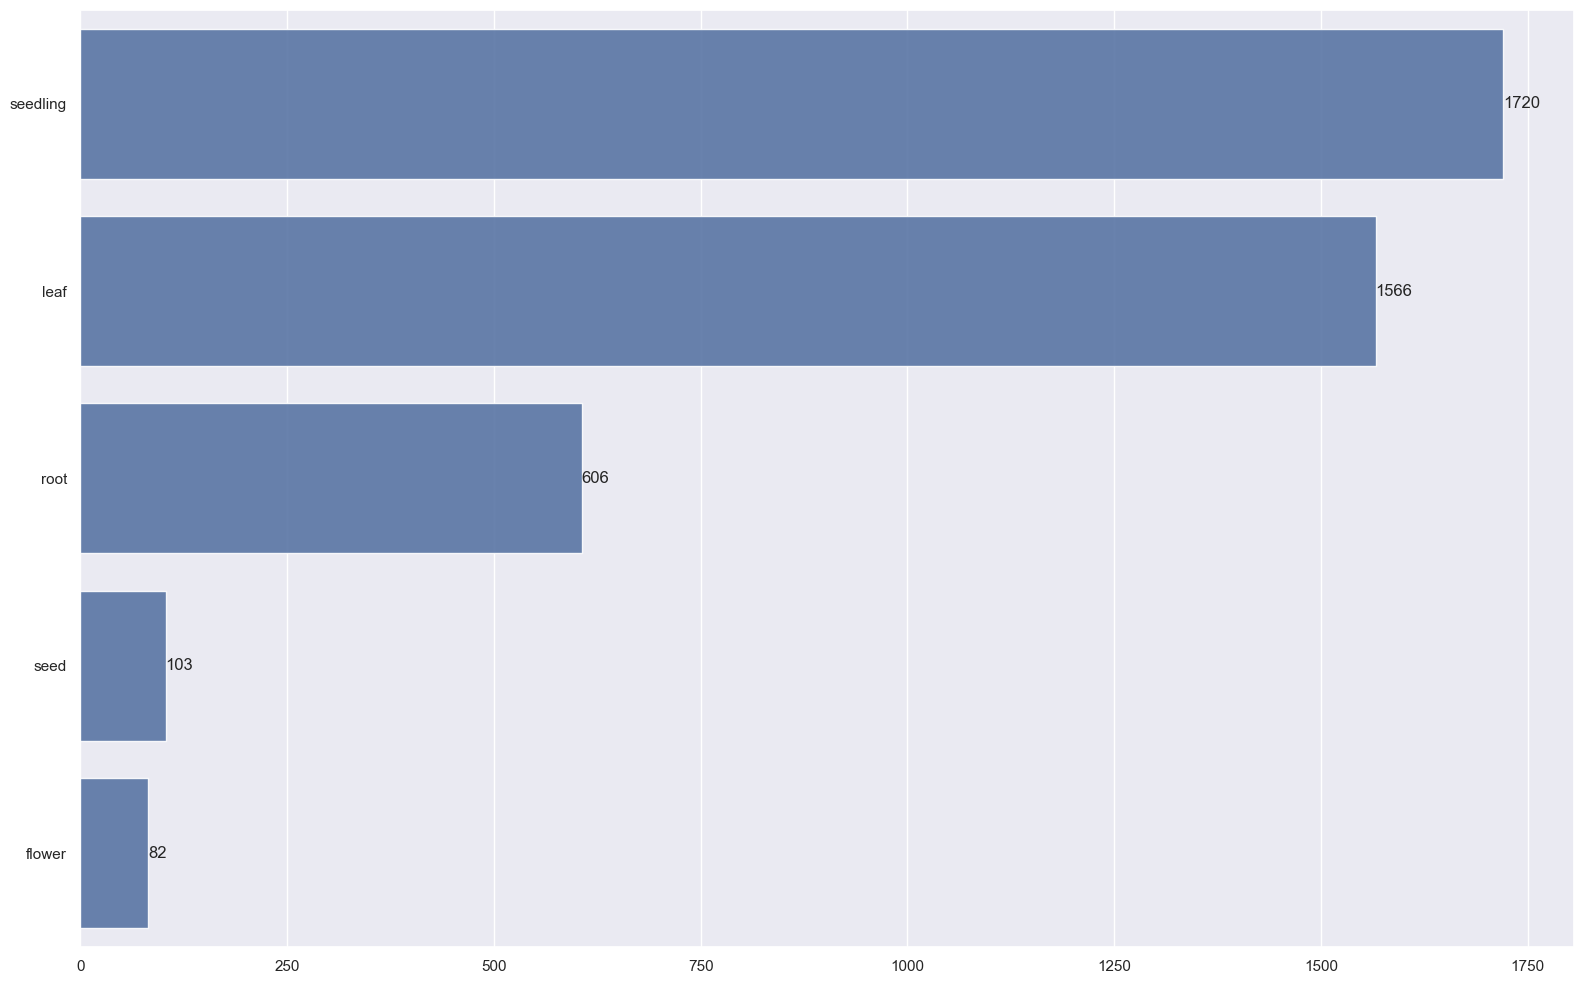

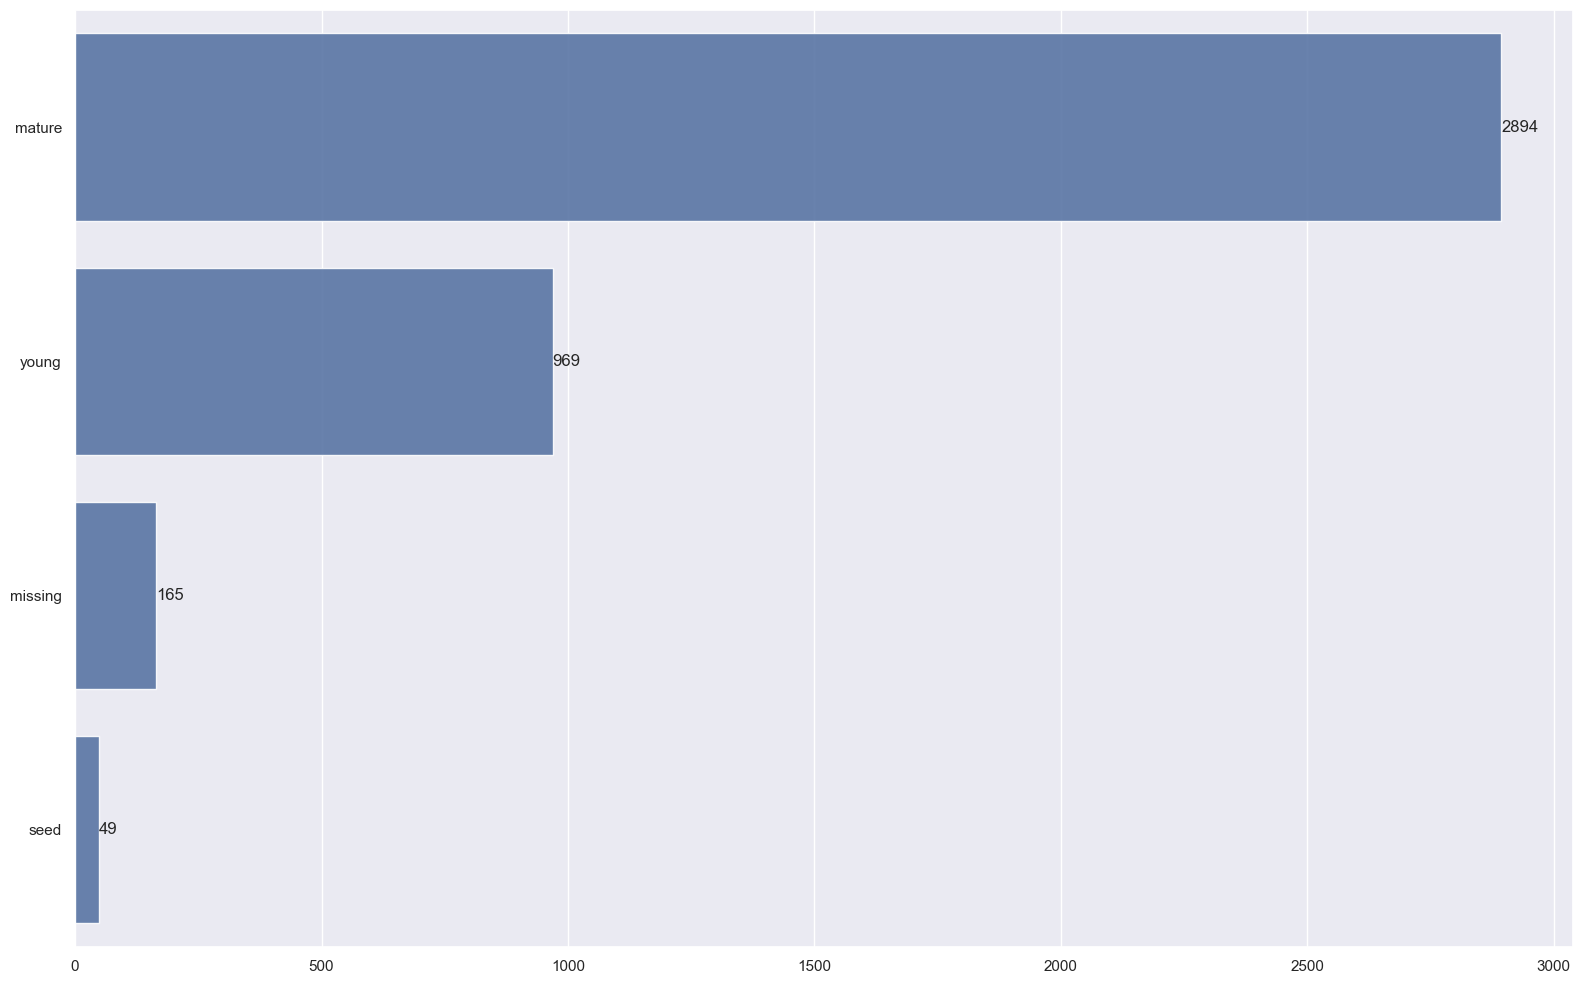

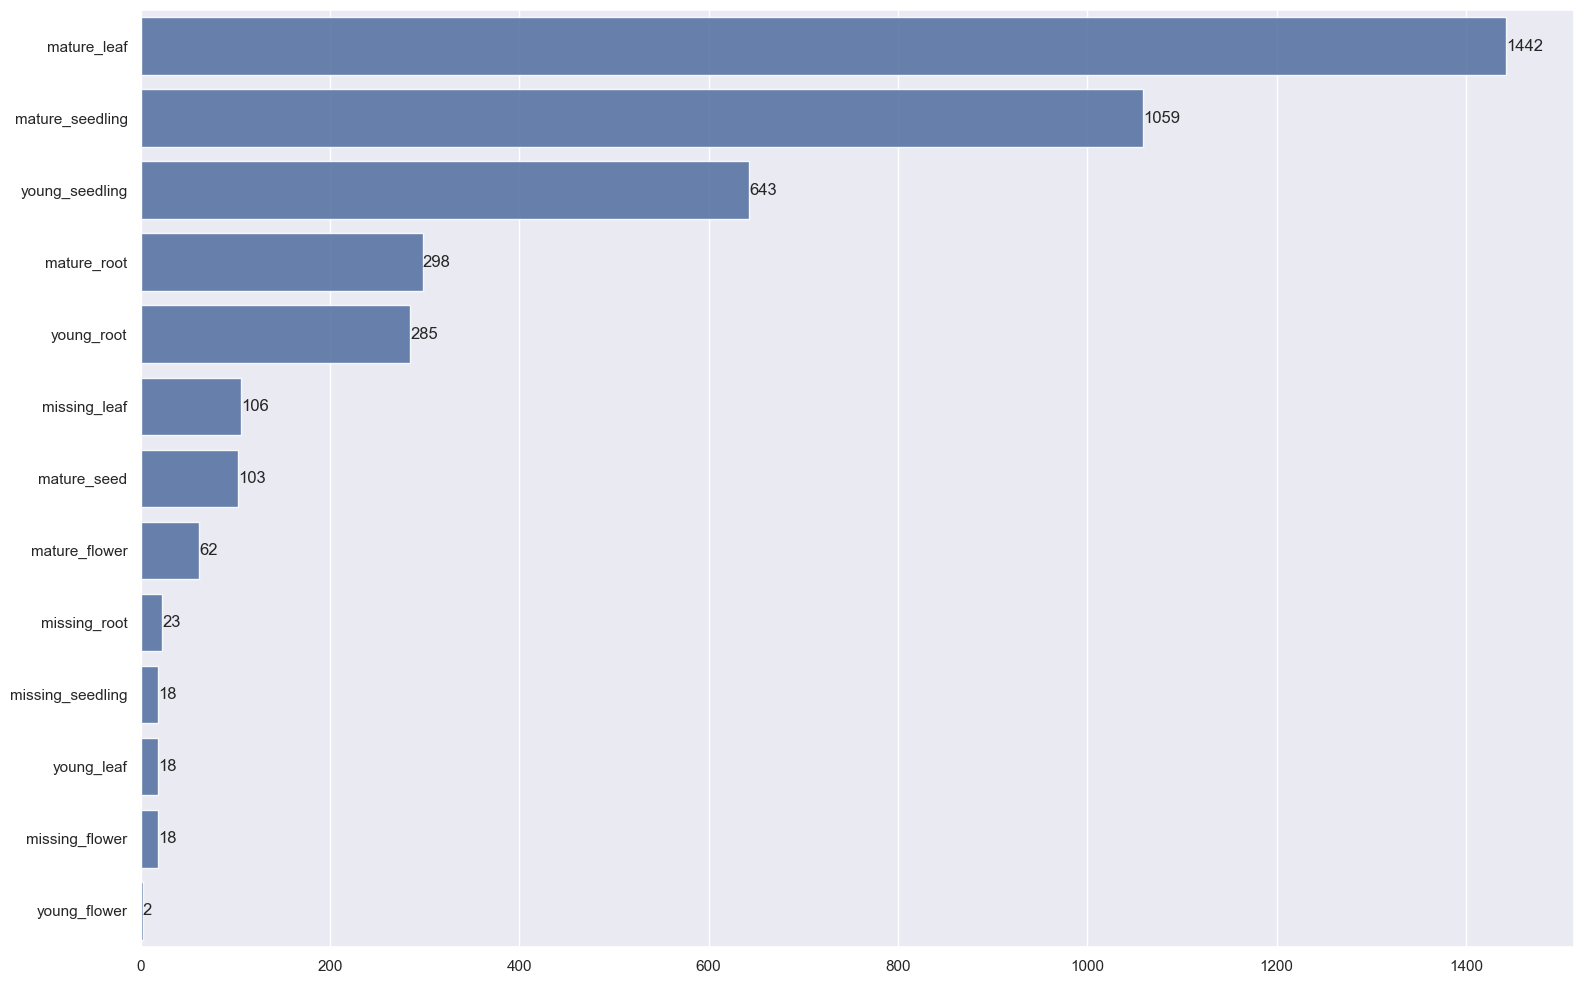

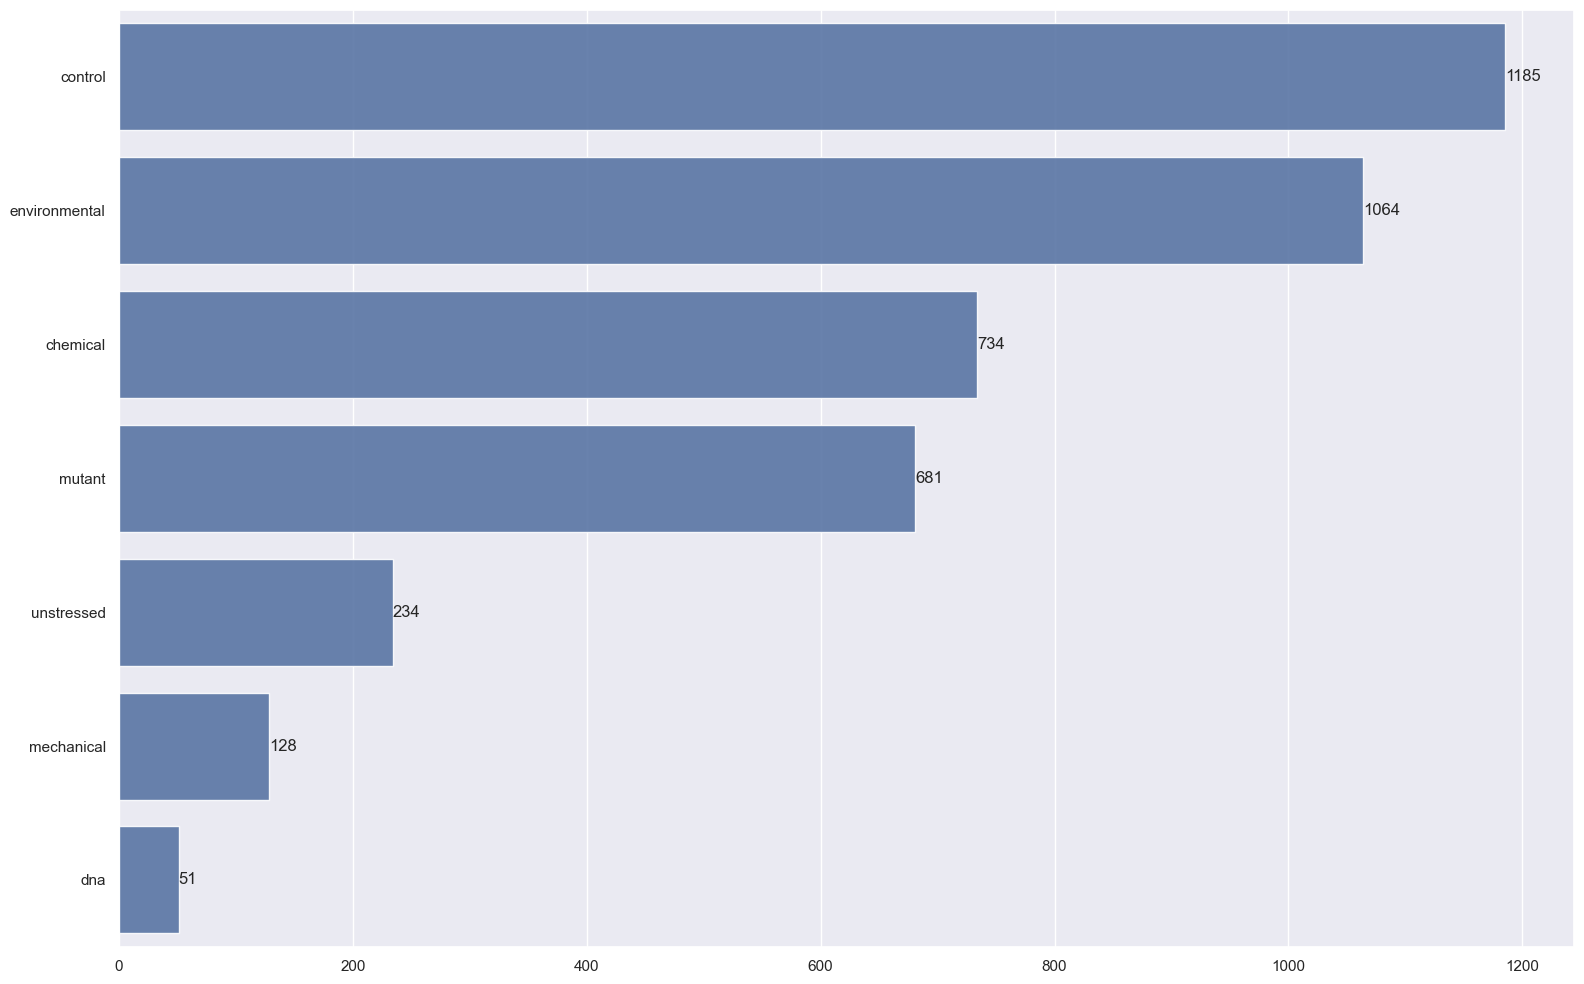

In [18]:
# Display the distribution of groups for all samples

for group in ['tissue', 'age', 'group', 'perturbation'] :
	analysis_metadata.distribution_barplot(
		data     = tissue_metadata,
		group    = group.capitalize(),
		filename = os.path.join(OUT_PLOT, 'distribution-' + group)
	)

	matplotlib.pyplot.show()

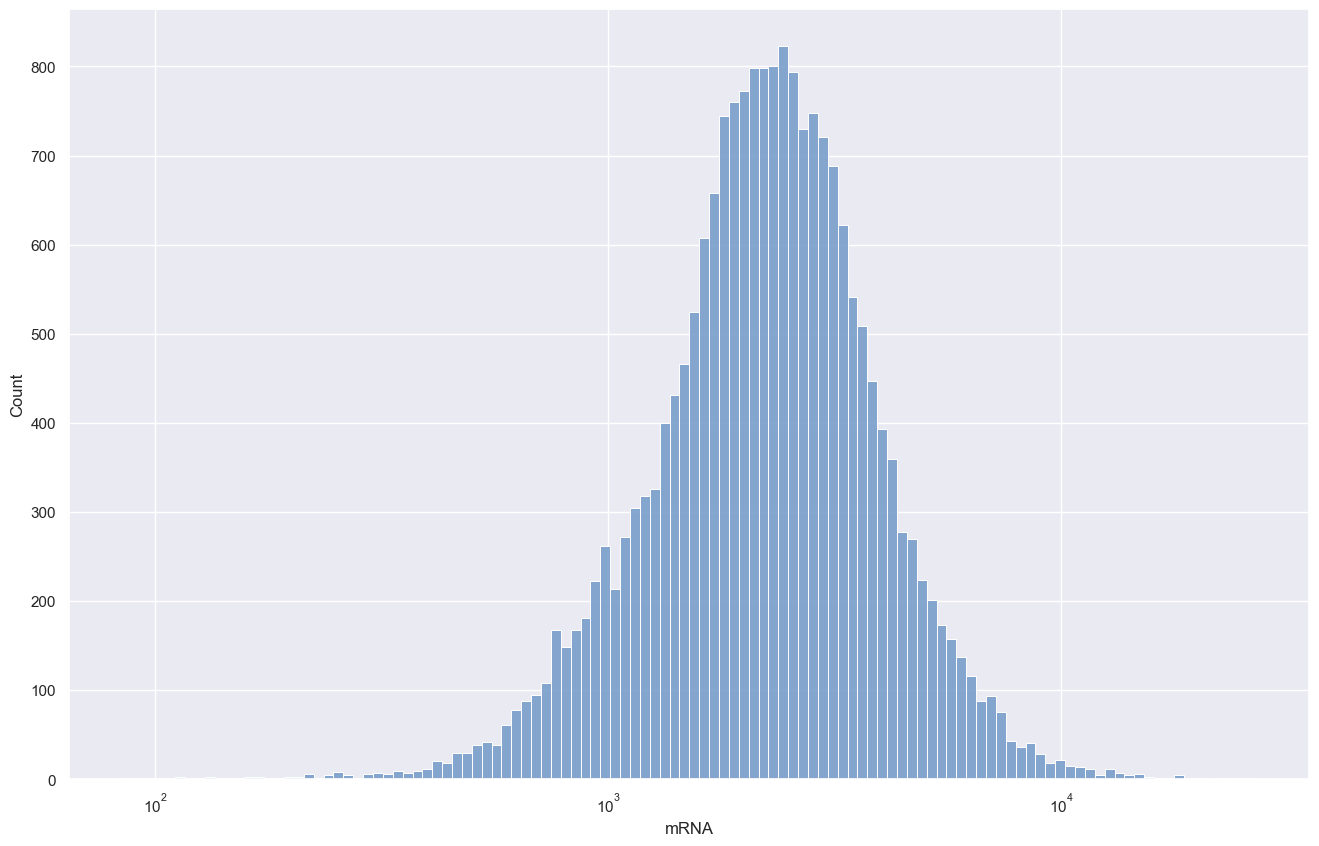

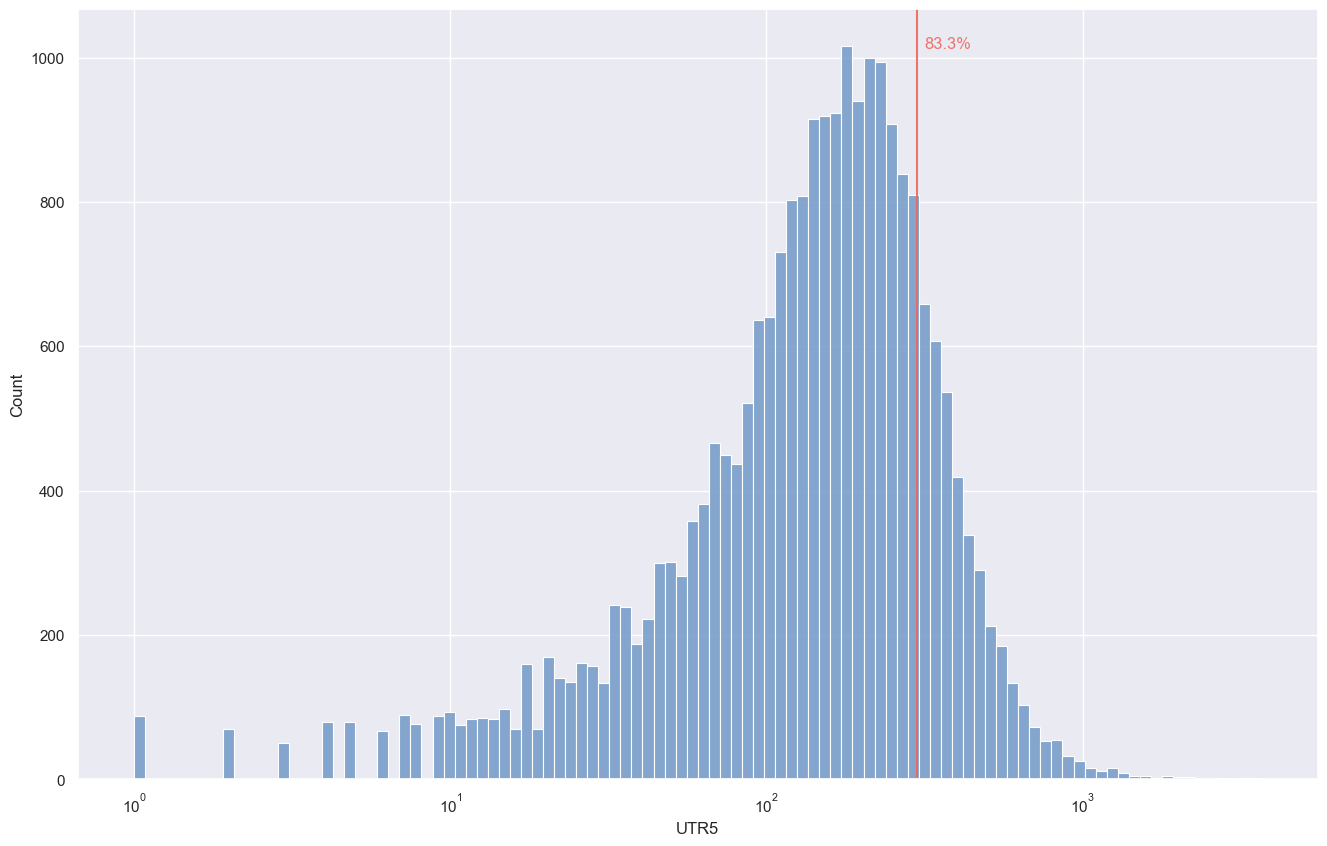

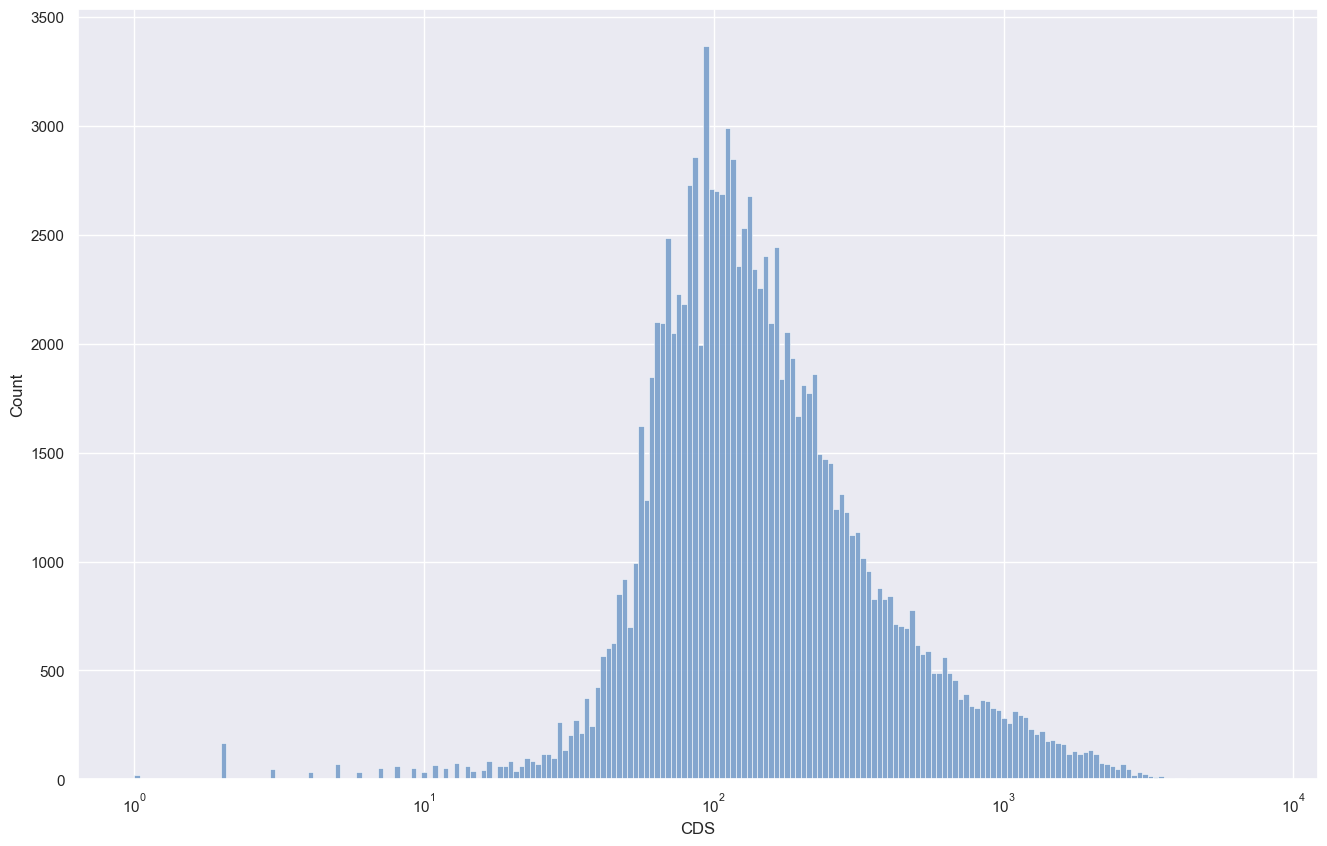

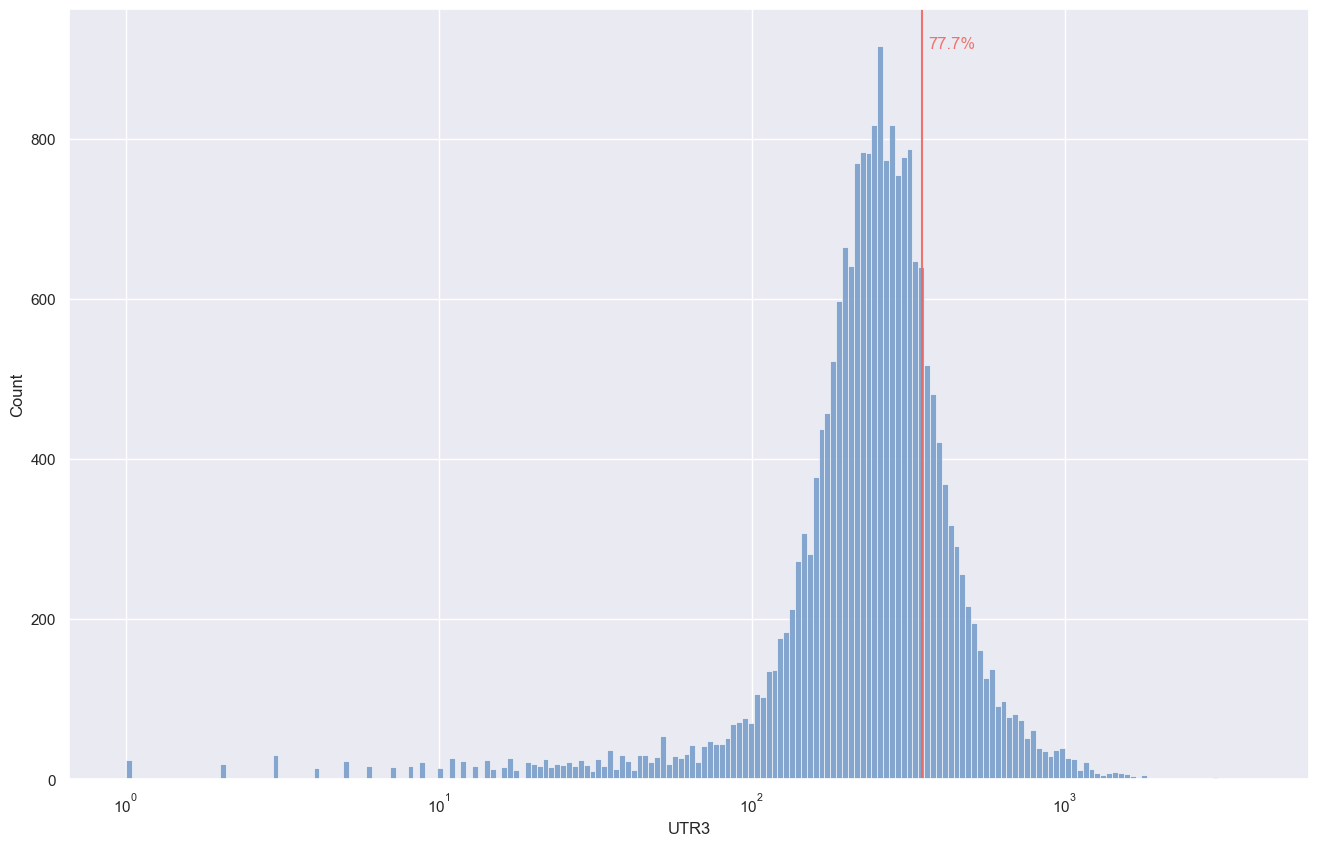

In [19]:
# Display the region length distributions per each region

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	for group, vline in zip(['mRNA', 'UTR5', 'CDS', 'UTR3'], [0, 300, 0, 350]) :
		analysis_annotation.length_histplot(
			data     = gene_annotation,
			value    = group,
			vline    = vline,
			filename = os.path.join(OUT_PLOT, 'length-region-' + group.lower())
		)

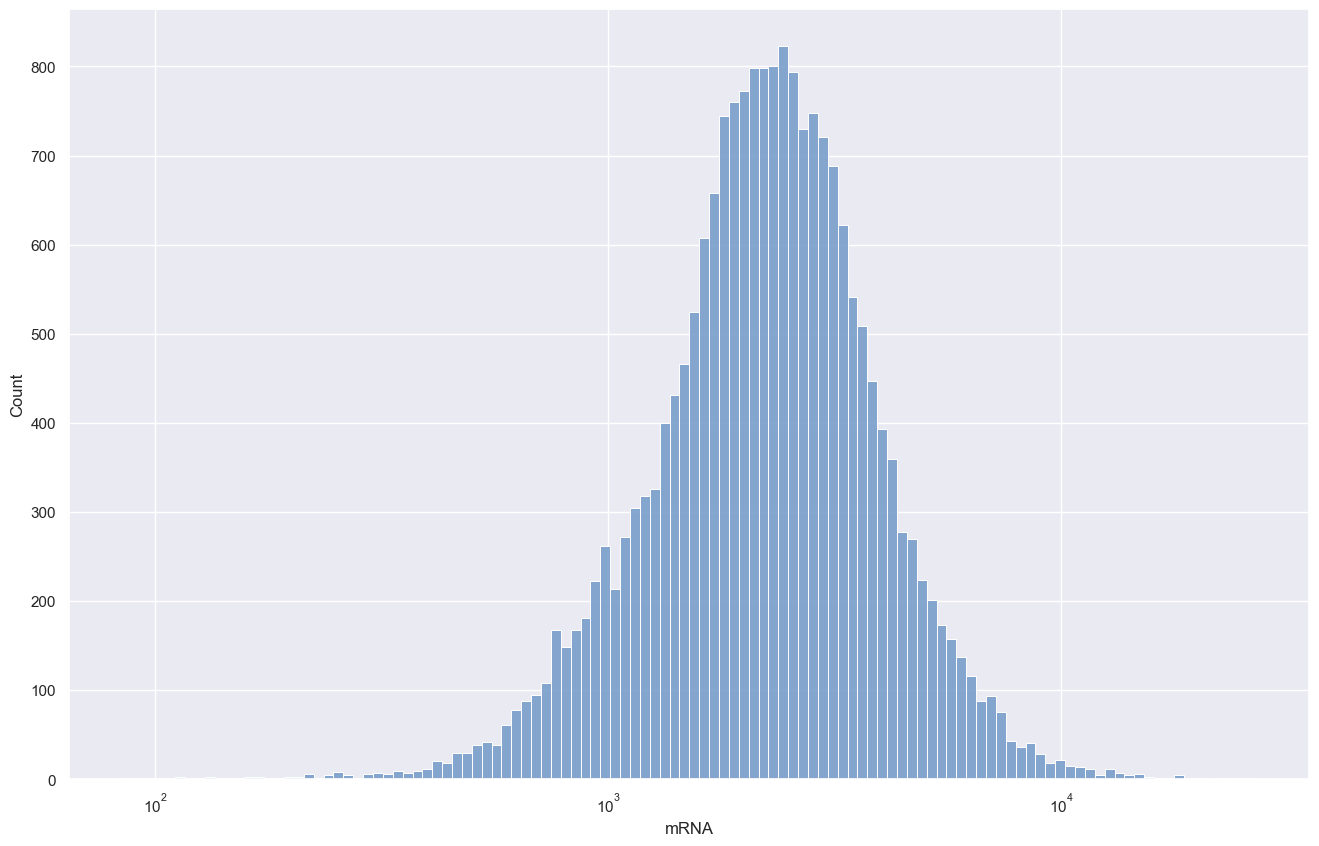

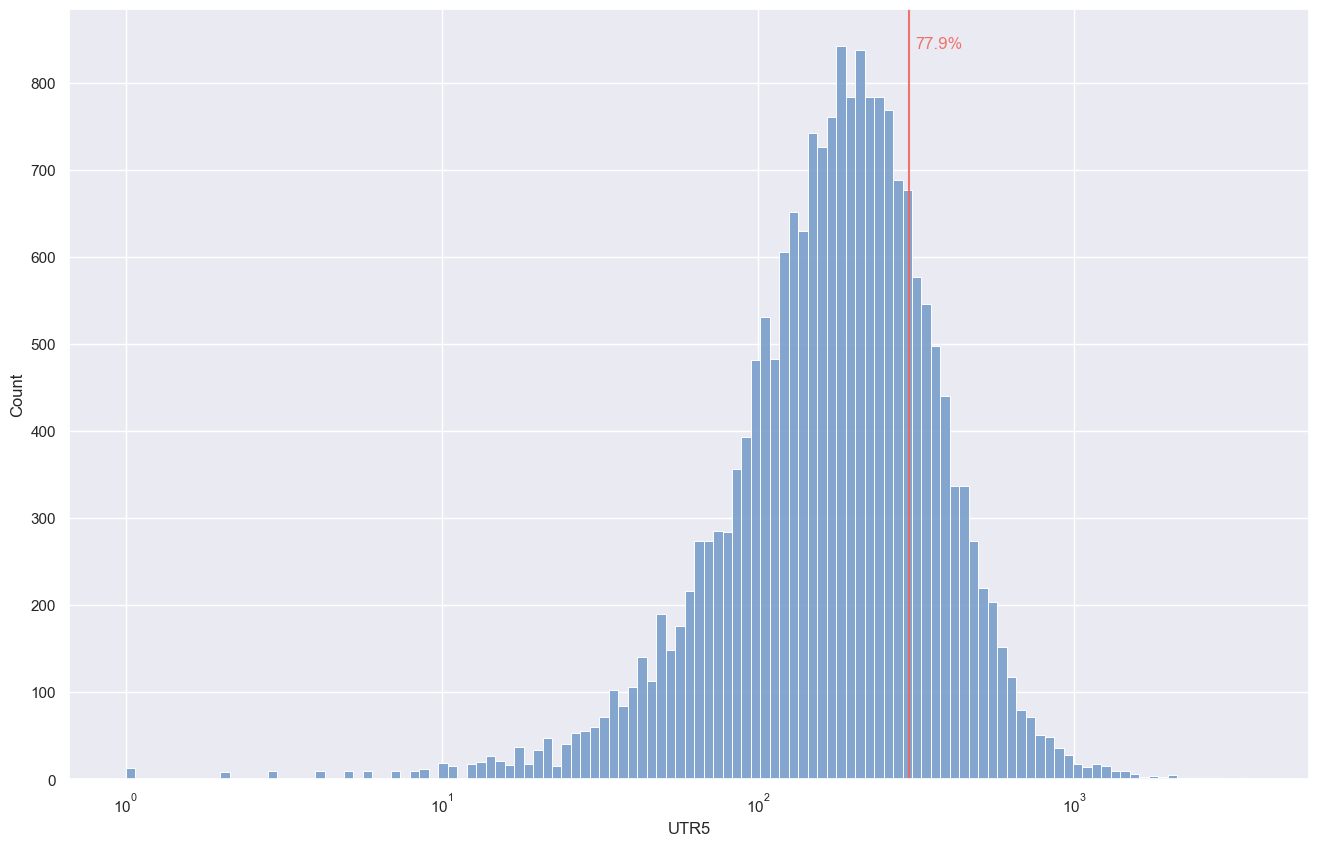

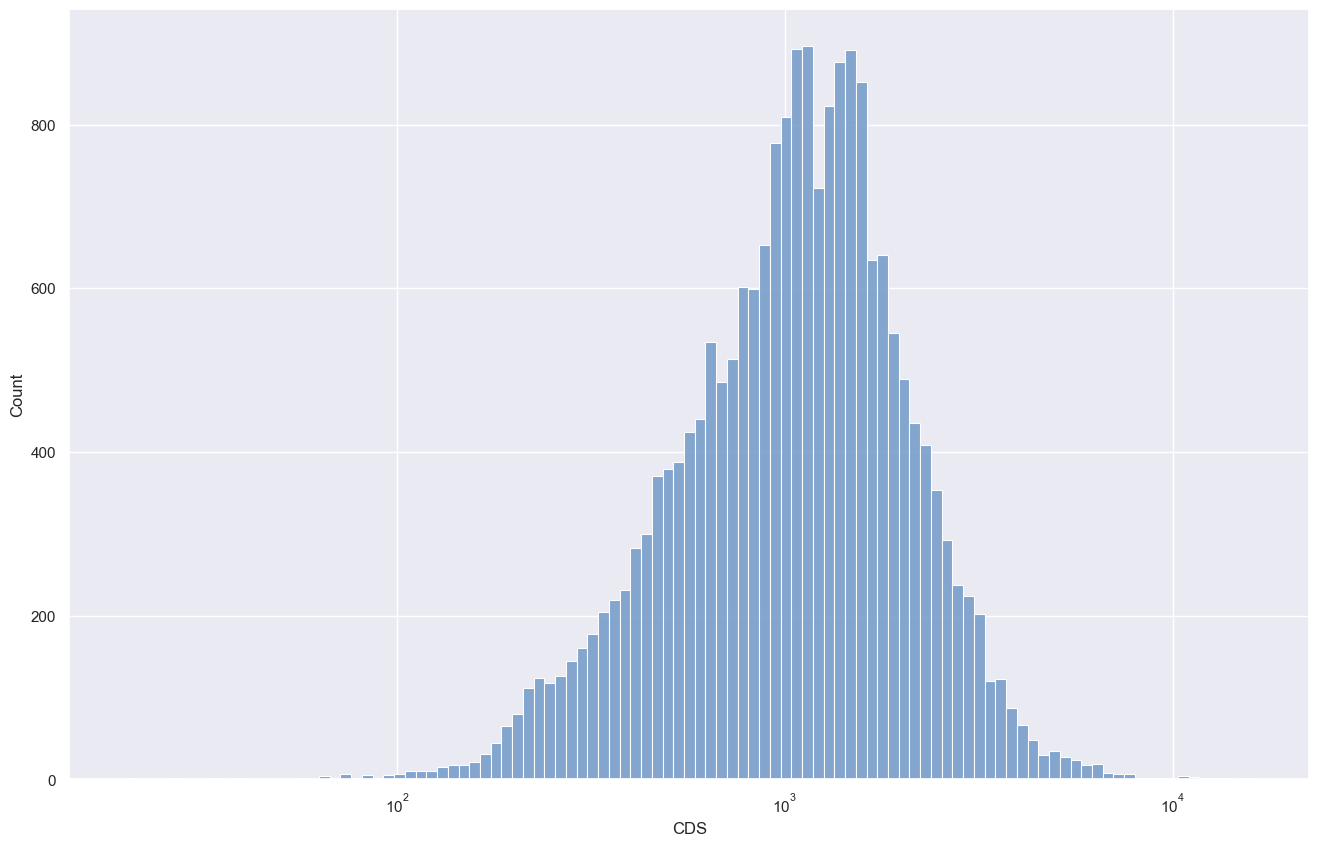

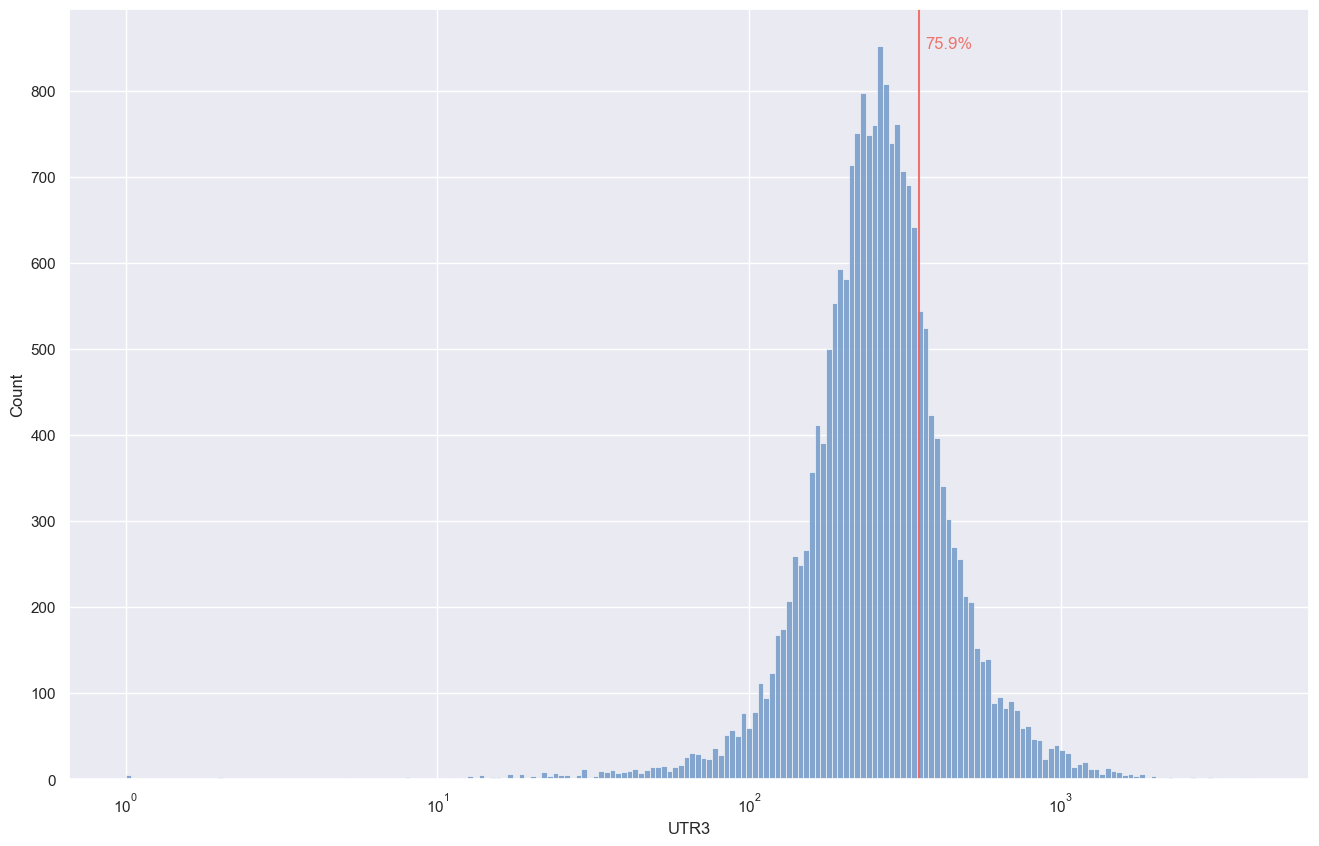

In [20]:
# Display the region length distributions per each region (grouped regions)

dataframe = analysis_annotation.group_regions(
	data    = gene_annotation,
	groupby = 'Transcript',
	regions = ['mRNA', 'UTR5', 'CDS', 'UTR3']
)

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	for group, vline in zip(['mRNA', 'UTR5', 'CDS', 'UTR3'], [0, 300, 0, 350]) :
		analysis_annotation.length_histplot(
			data     = dataframe,
			value    = group,
			vline    = vline,
			filename = os.path.join(OUT_PLOT, 'length-transcript-' + group.lower())
		)